# Scenario Validation Notebook

**Purpose**: Comprehensive validation and visualization of synthetic power market data

**Usage**: Update `SCENARIO_PATTERN` in the cell below to match your output file, then run all cells.

In [17]:
# ========== CONFIGURATION ==========
# Update this pattern to match your scenario output file
SCENARIO_PATTERN = "gas_crisis_scenario*.pkl"  # e.g., "gas_crisis_scenario*.pkl", "coal_phaseout_scenario*.pkl"
OUTPUT_DIR = "../outputs"

# Optional: manually define regime periods if your scenario has regimes
# Set to None for automatic detection or if no regimes
REGIME_PERIODS = None  # Example: [('normal', '2024-01-01', '2024-05-01'), ('crisis', '2024-05-01', '2024-09-01')]

# ==================================

In [18]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import time
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Increase plot quality
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

## 1. Data Loading

Automatically finds and loads the most recent output file matching the pattern.

In [19]:
def find_latest_output(output_dir, pattern):
    """Find the most recent output file matching the pattern."""
    output_dir = Path(output_dir)
    matches = list(output_dir.glob(pattern))
    
    if not matches:
        raise FileNotFoundError(f"No files found matching '{pattern}' in {output_dir}")
    
    # Sort by modification time (most recent first)
    matches.sort(key=lambda f: f.stat().st_mtime, reverse=True)
    latest = matches[0]
    
    print(f"Found {len(matches)} file(s) matching pattern:")
    for i, f in enumerate(matches[:5]):  # Show top 5
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(f.stat().st_mtime))
        marker = "<-- LOADING" if i == 0 else ""
        print(f"  {f.name:60s} {timestamp} {marker}")
    
    return latest

# Load data
print(f"Searching for: {SCENARIO_PATTERN}")
print(f"In directory: {Path(OUTPUT_DIR).resolve()}\n")

data_file = find_latest_output(OUTPUT_DIR, SCENARIO_PATTERN)
print(f"\nLoading: {data_file}\n")

df = pd.read_pickle(data_file)

# Ensure datetime index
if not isinstance(df.index, pd.DatetimeIndex):
    for col in ['ts', 'time', 'timestamp', 'date', 'datetime']:
        if col in df.columns:
            df.index = pd.to_datetime(df[col])
            break

# Basic info
print(f"✓ Loaded {len(df):,} timesteps")
print(f"  Date range: {df.index.min()} to {df.index.max()}")
print(f"  Duration: {(df.index.max() - df.index.min()).days} days")
print(f"  Columns: {len(df.columns)}")

Searching for: gas_crisis_scenario*.pkl
In directory: /Users/henrybaker/Repositories/synthetic-data-energy-markets/outputs

Found 1 file(s) matching pattern:
  gas_crisis_scenario_v1_2025_11_06_00_22.pkl                  2025-11-06 01:22:57 <-- LOADING

Loading: ../outputs/gas_crisis_scenario_v1_2025_11_06_00_22.pkl

✓ Loaded 8,760 timesteps
  Date range: 2024-01-01 00:00:00 to 2024-12-30 23:00:00
  Duration: 364 days
  Columns: 51


## 2. Data Preparation

Extract temporal features and identify available variables.

In [20]:
# Add temporal features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
df['is_weekend'] = df['day_of_week'].isin([5, 6])

# Identify available columns
gen_cols = [c for c in ['Q_nuclear', 'Q_coal', 'Q_gas', 'Q_wind', 'Q_solar'] if c in df.columns]
cap_cols = [c for c in ['cap.nuclear', 'cap.coal', 'cap.gas', 'cap.wind', 'cap.solar'] if c in df.columns]
fuel_cols = [c for c in ['fuel.gas', 'fuel.coal'] if c in df.columns]
avail_cols = [c for c in ['avail.nuclear', 'avail.coal', 'avail.gas', 'avail.wind', 'avail.solar'] if c in df.columns]

# All random variables
var_cols = [
    'fuel.gas', 'fuel.coal',
    'cap.nuclear', 'cap.coal', 'cap.gas', 'cap.wind', 'cap.solar',
    'avail.nuclear', 'avail.coal', 'avail.gas', 'avail.wind', 'avail.solar',
    'eta_lb.coal', 'eta_ub.coal', 'eta_lb.gas', 'eta_ub.gas',
    'bid.nuclear.min', 'bid.nuclear.max',
    'bid.wind.min', 'bid.wind.max',
    'bid.solar.min', 'bid.solar.max'
]
var_cols = [c for c in var_cols if c in df.columns]

print(f"Available data:")
print(f"  Generation columns: {len(gen_cols)}")
print(f"  Capacity columns: {len(cap_cols)}")
print(f"  Fuel price columns: {len(fuel_cols)}")
print(f"  Availability columns: {len(avail_cols)}")
print(f"  Total random variables: {len(var_cols)}")

Available data:
  Generation columns: 5
  Capacity columns: 5
  Fuel price columns: 2
  Availability columns: 5
  Total random variables: 22


## 3. Overview Dashboard

High-level view of market outcomes over the full simulation period.

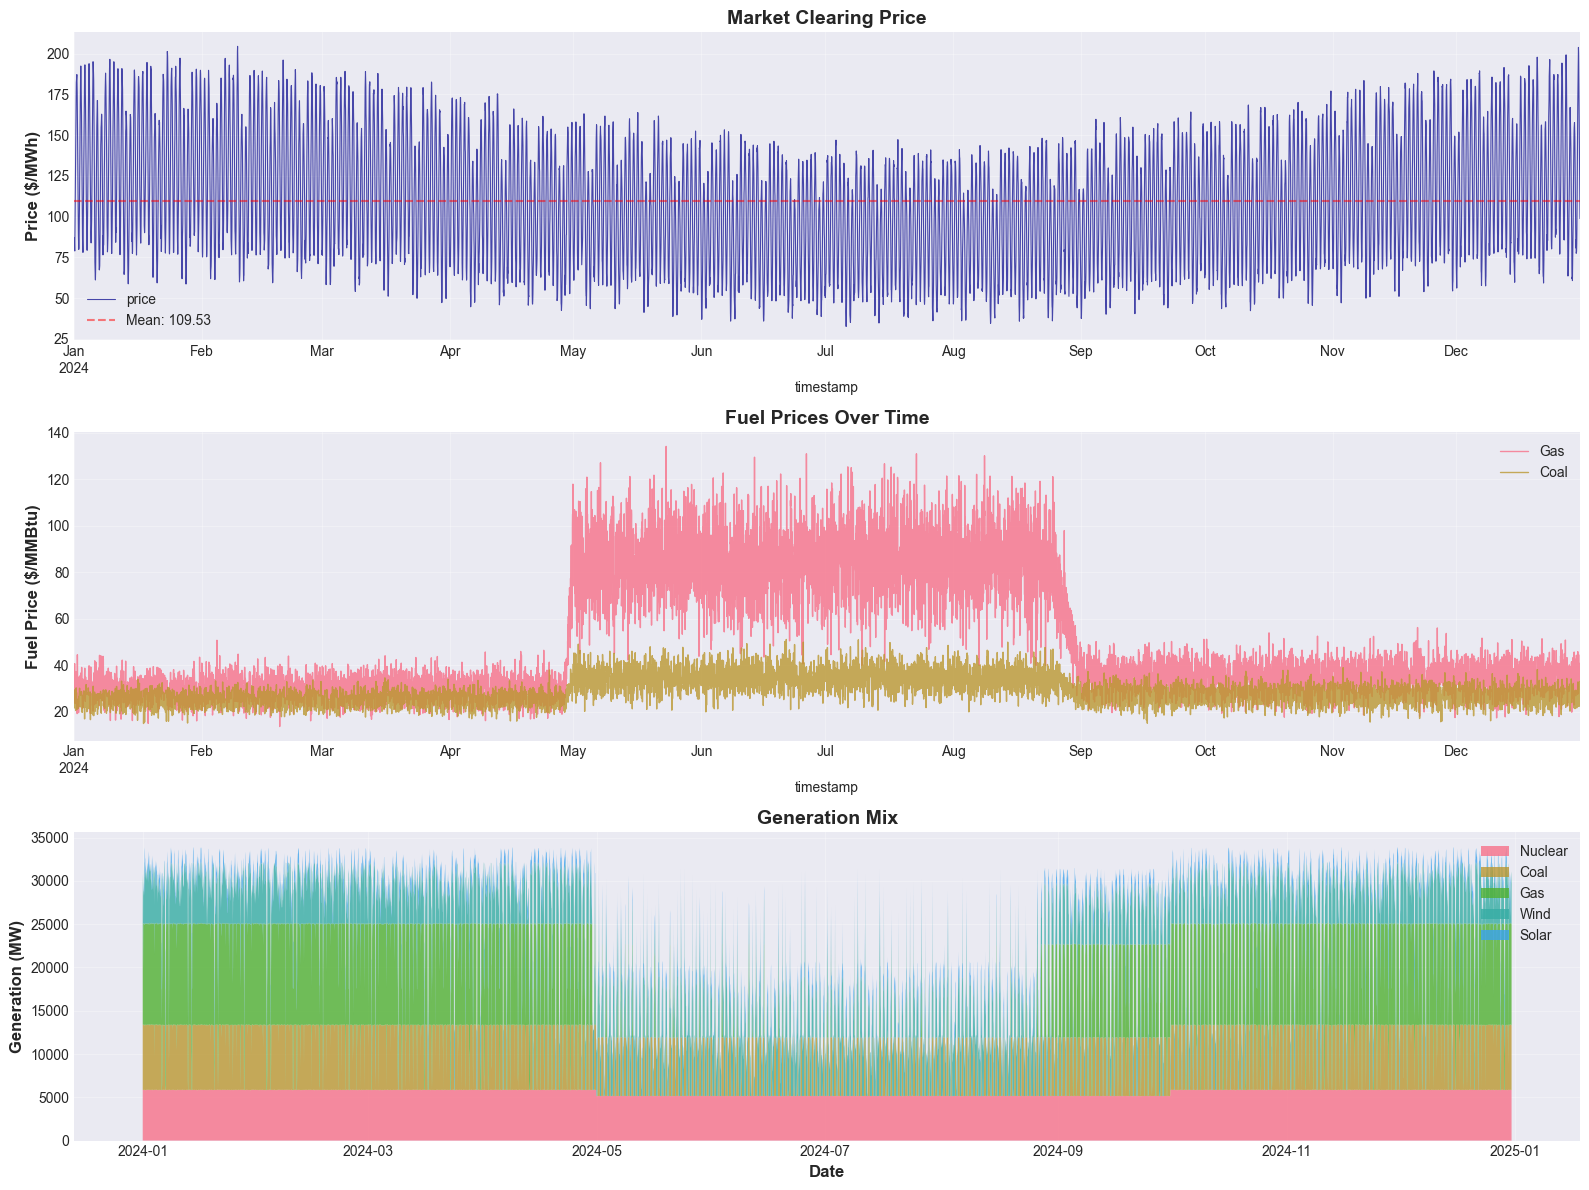

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: Market Clearing Price
ax = axes[0]
# Daily average for cleaner viz if data is long
if len(df) > 10000:
    df['price'].resample('D').mean().plot(ax=ax, linewidth=1, alpha=0.8, color='darkblue')
    ax.set_title('Market Clearing Price (Daily Average)', fontsize=14, fontweight='bold')
else:
    df['price'].plot(ax=ax, linewidth=0.8, alpha=0.7, color='darkblue')
    ax.set_title('Market Clearing Price', fontsize=14, fontweight='bold')
ax.set_ylabel('Price ($/MWh)', fontsize=12, fontweight='bold')
ax.axhline(df['price'].mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean: {df["price"].mean():.2f}')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Fuel Prices (if available)
ax = axes[1]
if fuel_cols:
    for col in fuel_cols:
        label = col.replace('fuel.', '').capitalize()
        if len(df) > 10000:
            df[col].resample('D').mean().plot(ax=ax, label=label, linewidth=1.5, alpha=0.8)
        else:
            df[col].plot(ax=ax, label=label, linewidth=1, alpha=0.8)
    ax.set_title('Fuel Prices Over Time', fontsize=14, fontweight='bold')
    ax.set_ylabel('Fuel Price ($/MMBtu)', fontsize=12, fontweight='bold')
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No fuel price data available', ha='center', va='center', transform=ax.transAxes)
    ax.axis('off')
ax.grid(True, alpha=0.3)

# Plot 3: Generation Mix
ax = axes[2]
if gen_cols:
    # Daily average for stacked area
    if len(df) > 10000:
        daily_gen = df[gen_cols].resample('D').mean()
    else:
        daily_gen = df[gen_cols]
    
    labels = [c.replace('Q_', '').capitalize() for c in gen_cols]
    ax.stackplot(daily_gen.index, *[daily_gen[c] for c in gen_cols], labels=labels, alpha=0.8)
    ax.set_title('Generation Mix', fontsize=14, fontweight='bold')
    ax.set_ylabel('Generation (MW)', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Variable Distributions

Histograms showing the distribution of all random variables.

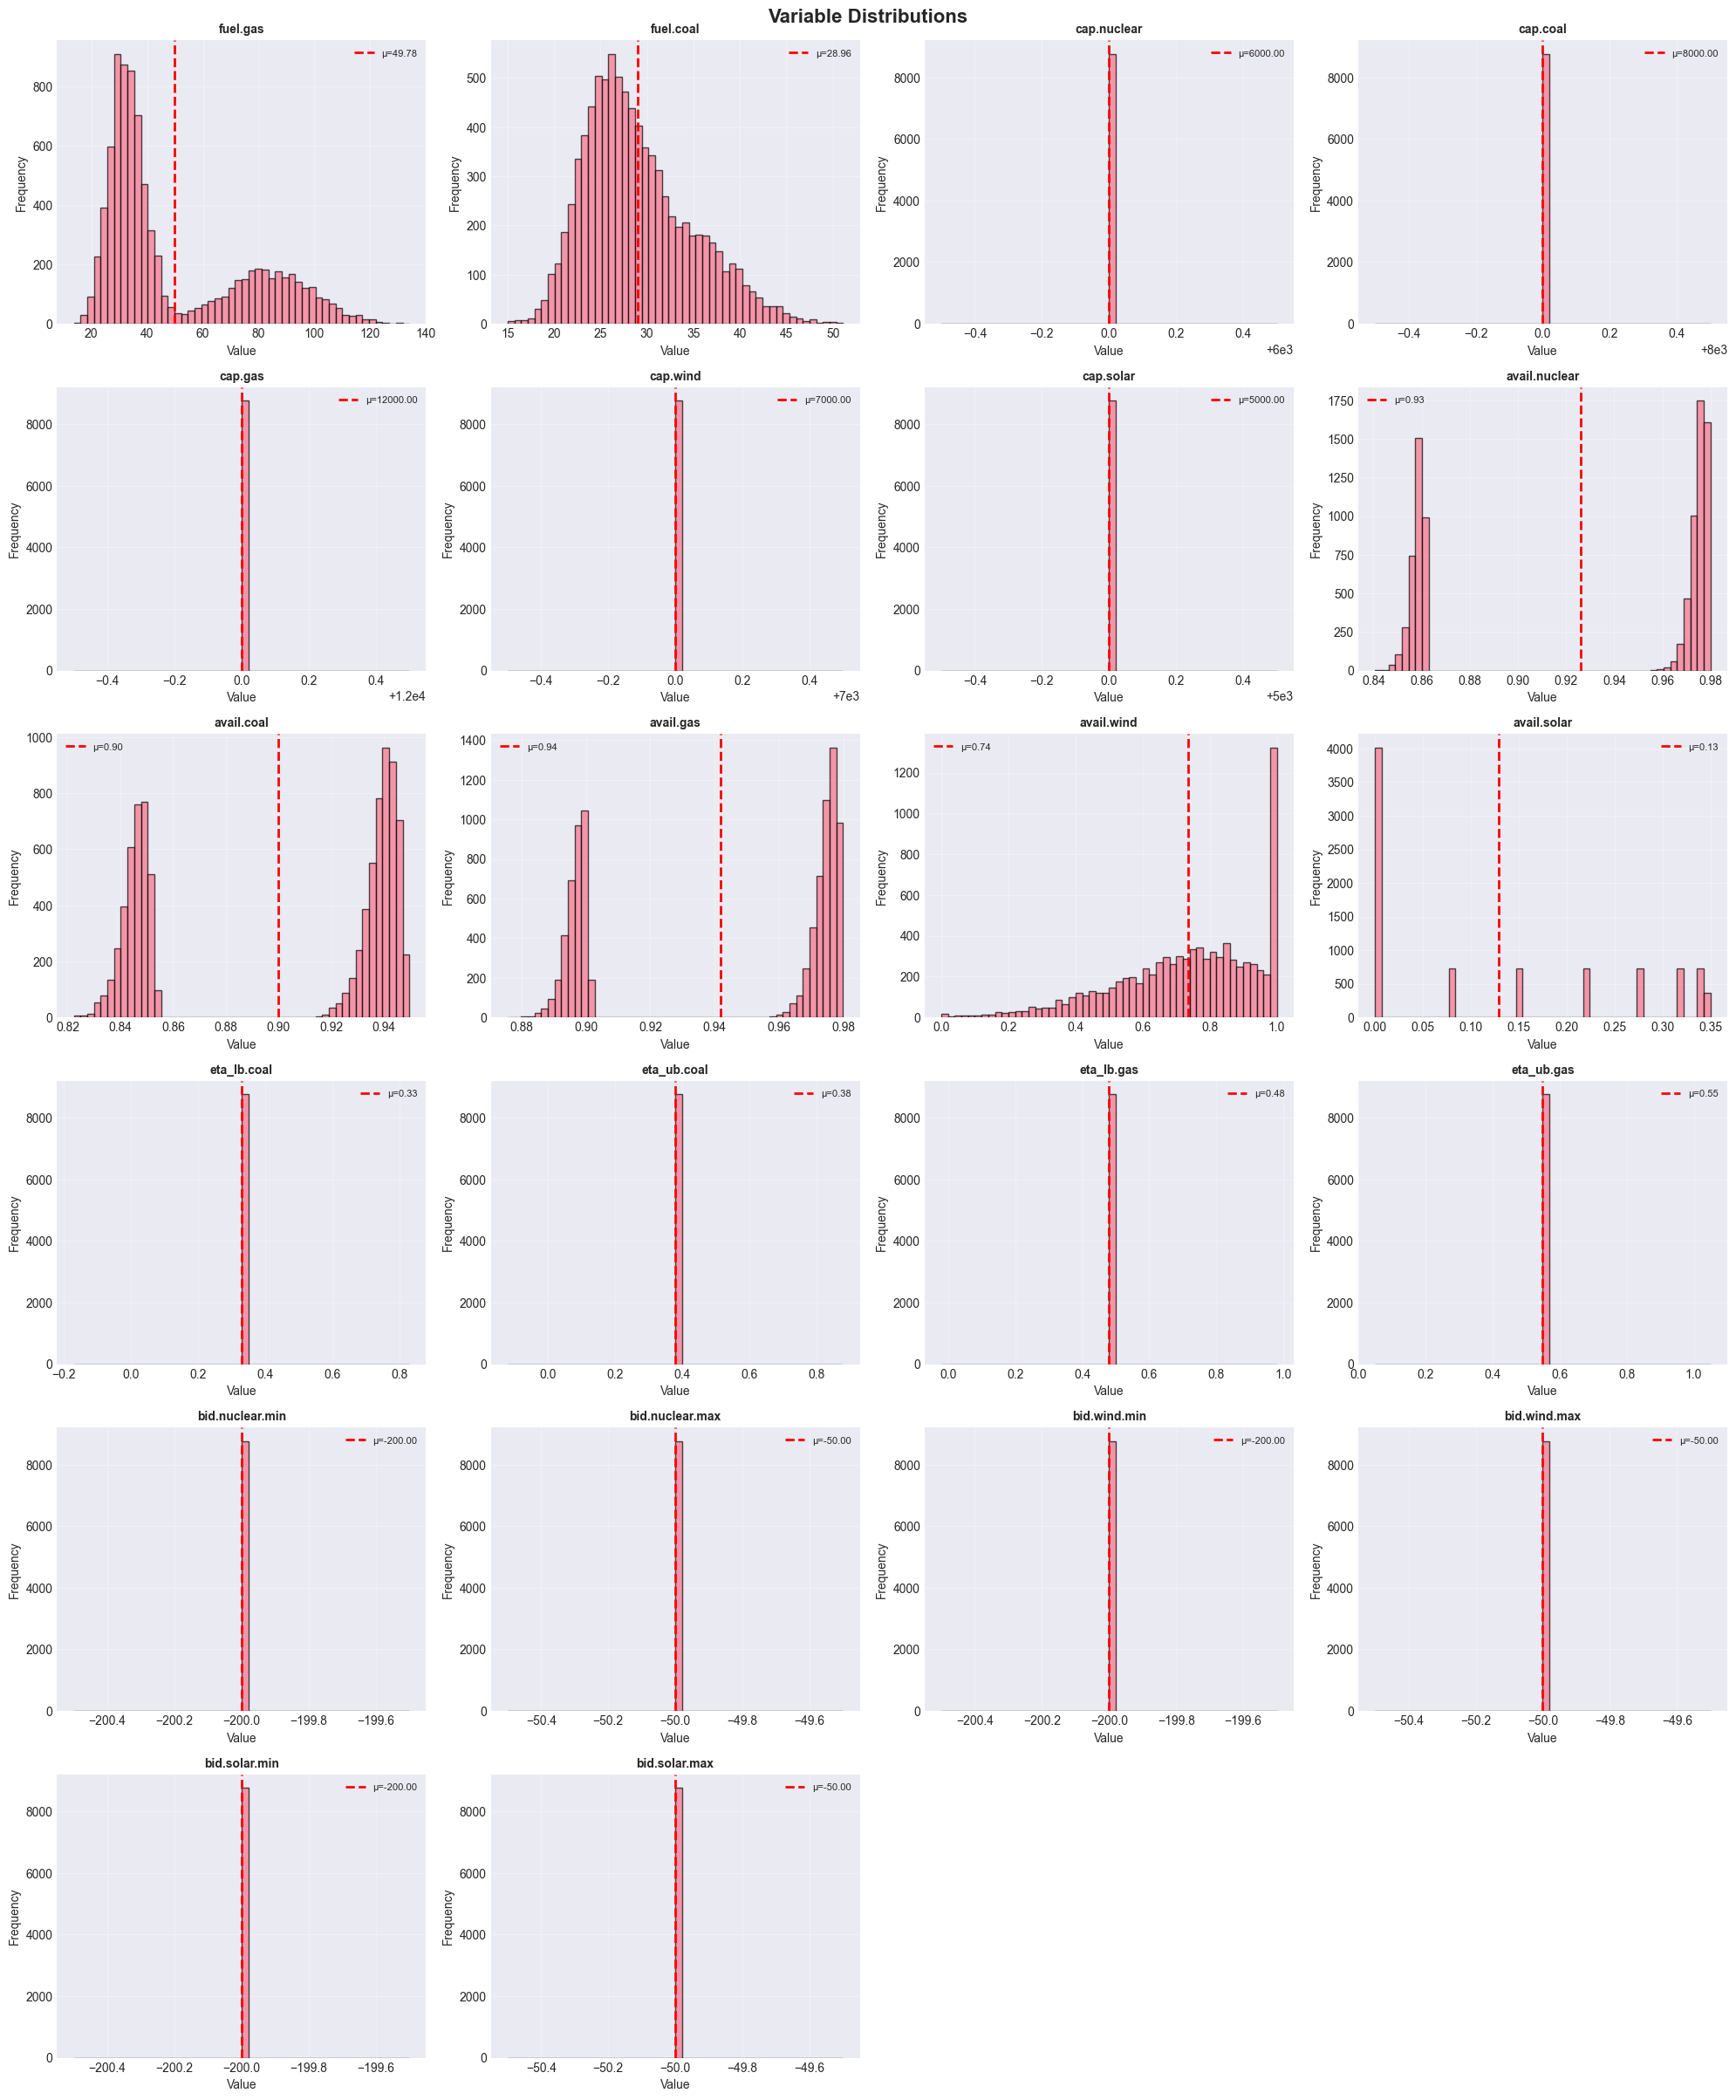

In [22]:
if var_cols:
    n_vars = len(var_cols)
    n_cols = 4
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(var_cols):
        ax = axes[idx]
        df[col].hist(bins=50, ax=ax, alpha=0.7, edgecolor='black')
        
        mean_val = df[col].mean()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'μ={mean_val:.2f}')
        
        ax.set_title(col, fontsize=10, fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(n_vars, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Variable Distributions', fontsize=16, fontweight='bold', y=1.001)
    plt.show()
else:
    print("No variable columns found for distribution analysis")

## 5. Variable Time Series

Time evolution of all random variables.

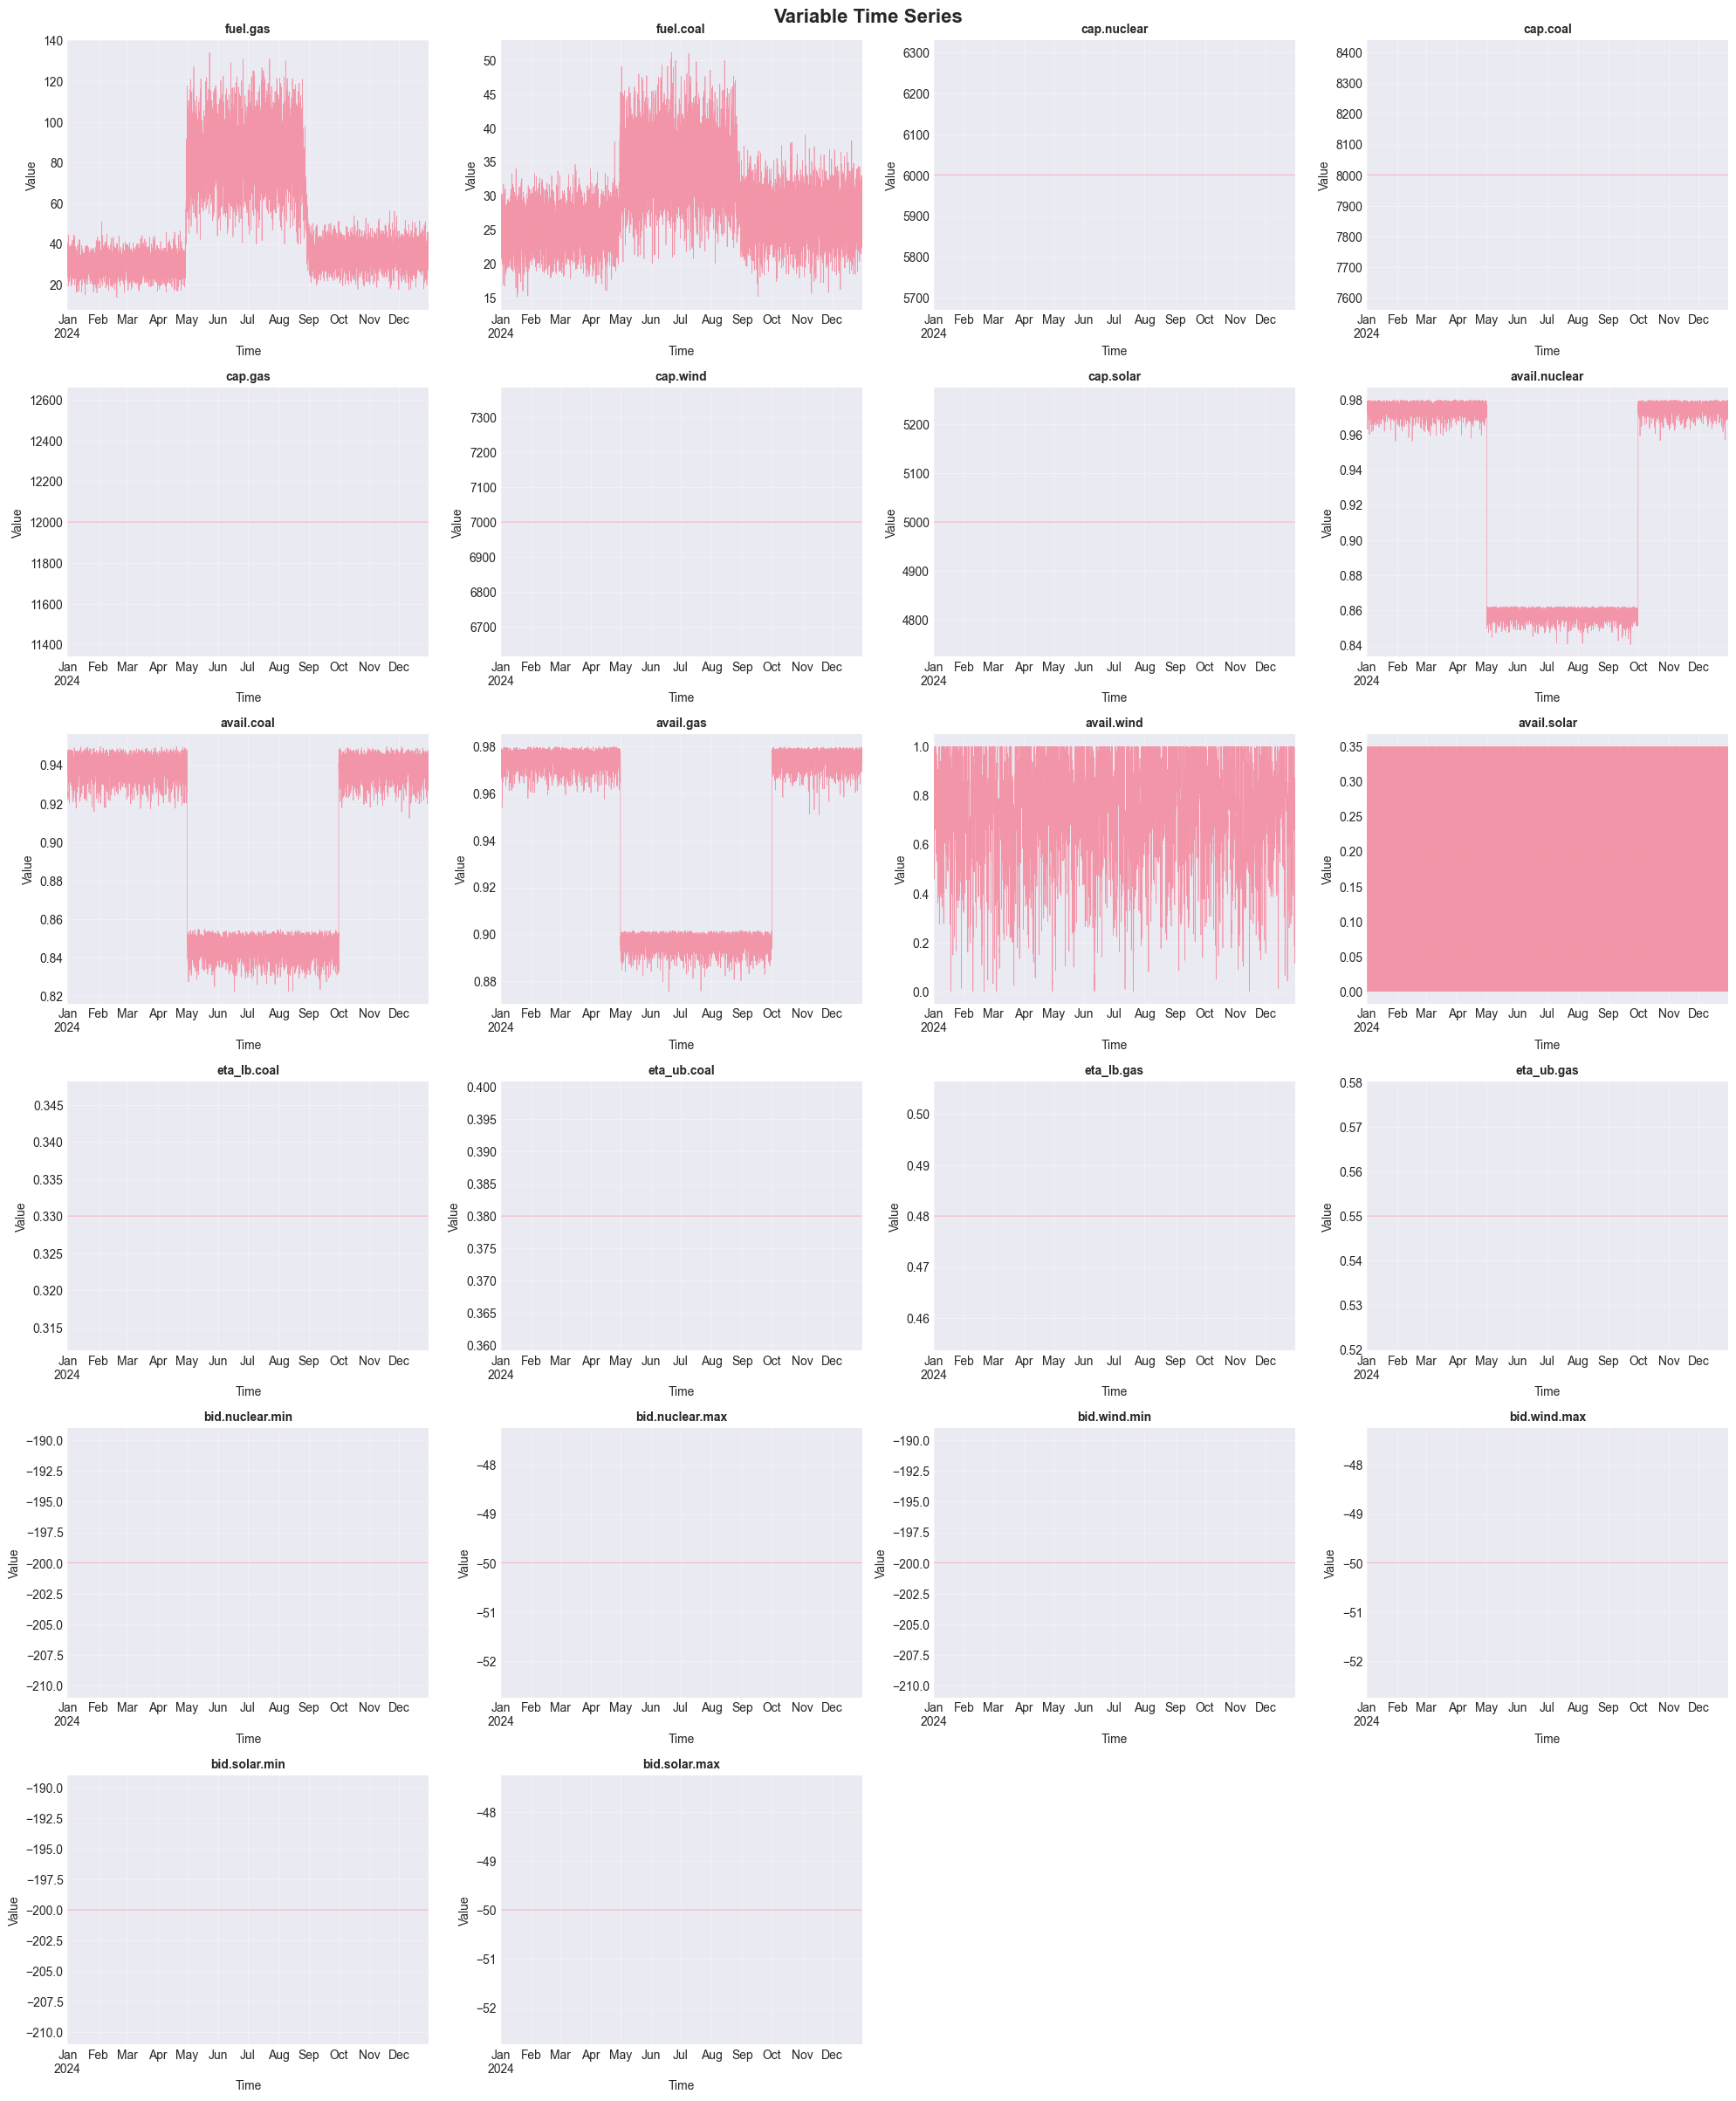

In [23]:
if var_cols:
    n_vars = len(var_cols)
    n_cols = 4
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(var_cols):
        ax = axes[idx]
        
        # Downsample if too many points
        if len(df) > 10000:
            df[col].resample('D').mean().plot(ax=ax, linewidth=1, alpha=0.8)
        else:
            df[col].plot(ax=ax, linewidth=0.5, alpha=0.7)
        
        ax.set_title(col, fontsize=10, fontweight='bold')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(n_vars, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Variable Time Series', fontsize=16, fontweight='bold', y=1.001)
    plt.show()

## 6. Demand Analysis

Validation of demand seasonality patterns (daily and annual).

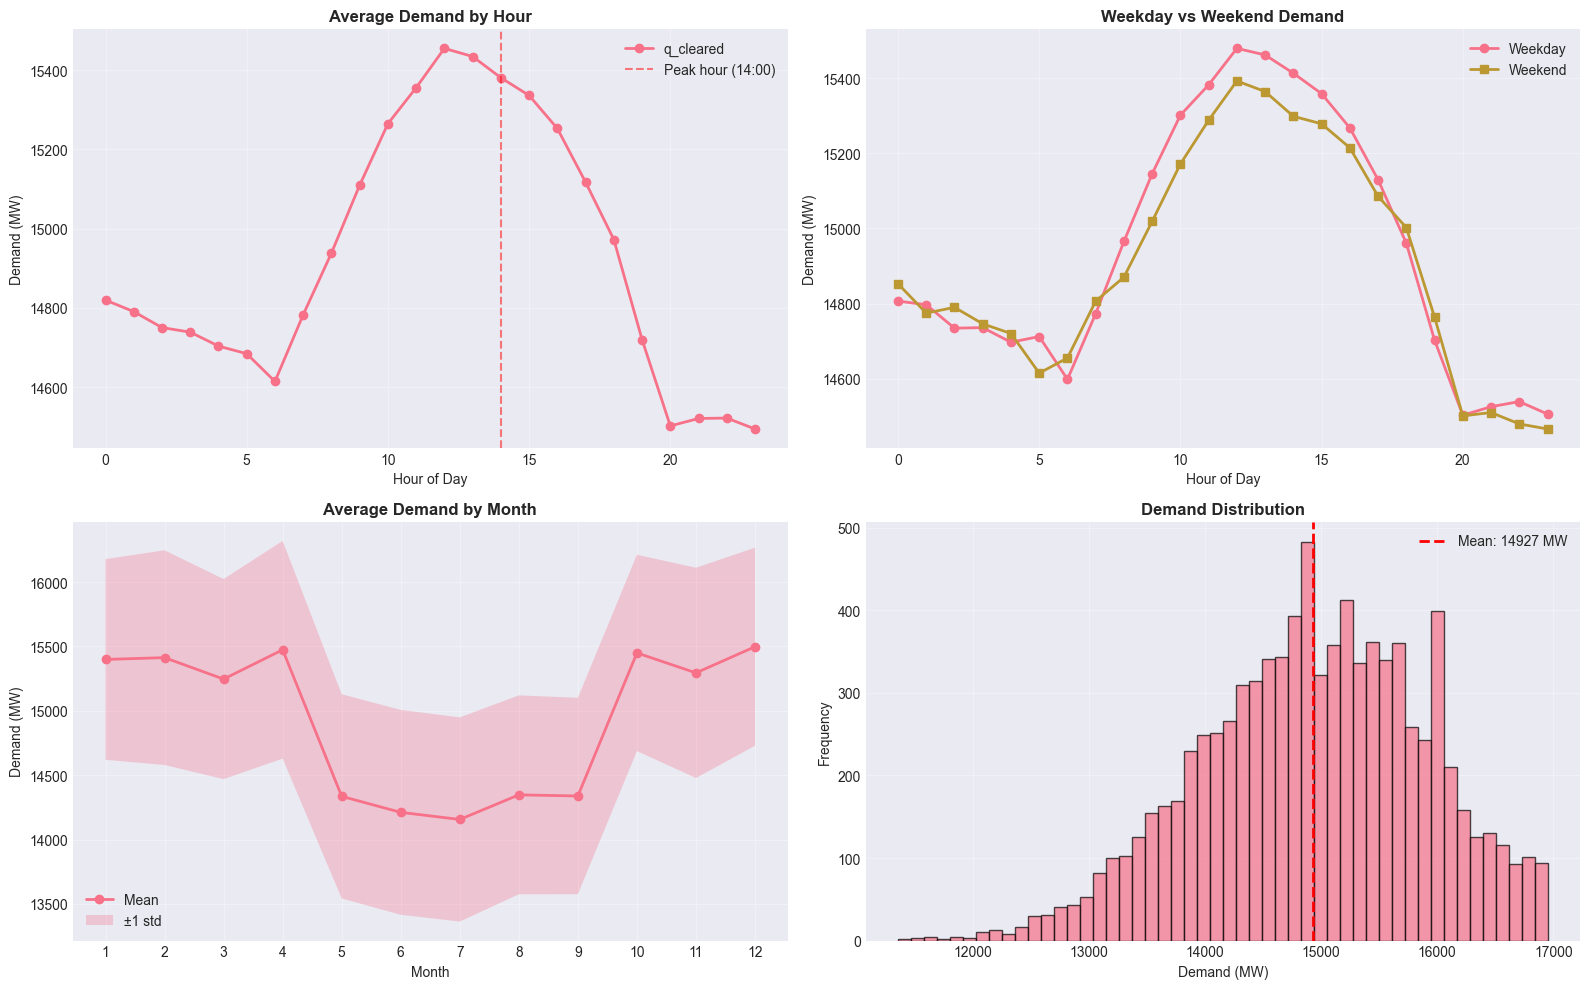


Demand Statistics:
  Overall mean: 14927.49 MW
  Weekday mean: 14937.36 MW
  Weekend mean: 14902.73 MW
  Weekend drop: 0.23%


In [24]:
if 'q_cleared' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Hourly pattern
    ax = axes[0, 0]
    hourly_demand = df.groupby('hour')['q_cleared'].mean()
    hourly_demand.plot(ax=ax, marker='o', linewidth=2)
    ax.axvline(14, color='red', linestyle='--', alpha=0.5, label='Peak hour (14:00)')
    ax.set_title('Average Demand by Hour', fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Demand (MW)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Weekday vs Weekend
    ax = axes[0, 1]
    weekday_demand = df[~df['is_weekend']].groupby('hour')['q_cleared'].mean()
    weekend_demand = df[df['is_weekend']].groupby('hour')['q_cleared'].mean()
    weekday_demand.plot(ax=ax, marker='o', label='Weekday', linewidth=2)
    weekend_demand.plot(ax=ax, marker='s', label='Weekend', linewidth=2)
    ax.set_title('Weekday vs Weekend Demand', fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Demand (MW)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Monthly pattern
    ax = axes[1, 0]
    monthly_demand = df.groupby('month')['q_cleared'].mean()
    monthly_std = df.groupby('month')['q_cleared'].std()
    monthly_demand.plot(ax=ax, marker='o', linewidth=2, label='Mean')
    ax.fill_between(monthly_demand.index,
                    monthly_demand - monthly_std,
                    monthly_demand + monthly_std,
                    alpha=0.3, label='±1 std')
    ax.set_title('Average Demand by Month', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel('Demand (MW)')
    ax.set_xticks(range(1, 13))
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Distribution
    ax = axes[1, 1]
    df['q_cleared'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
    ax.axvline(df['q_cleared'].mean(), color='red', linestyle='--', linewidth=2,
              label=f'Mean: {df["q_cleared"].mean():.0f} MW')
    ax.set_title('Demand Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Demand (MW)')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nDemand Statistics:")
    print(f"  Overall mean: {df['q_cleared'].mean():.2f} MW")
    print(f"  Weekday mean: {df[~df['is_weekend']]['q_cleared'].mean():.2f} MW")
    print(f"  Weekend mean: {df[df['is_weekend']]['q_cleared'].mean():.2f} MW")
    weekend_drop = ((df[~df['is_weekend']]['q_cleared'].mean() - df[df['is_weekend']]['q_cleared'].mean()) / 
                   df[~df['is_weekend']]['q_cleared'].mean() * 100)
    print(f"  Weekend drop: {weekend_drop:.2f}%")
else:
    print("No demand data (q_cleared) available")

## 7. Renewable Availability

Analysis of wind and solar availability patterns.

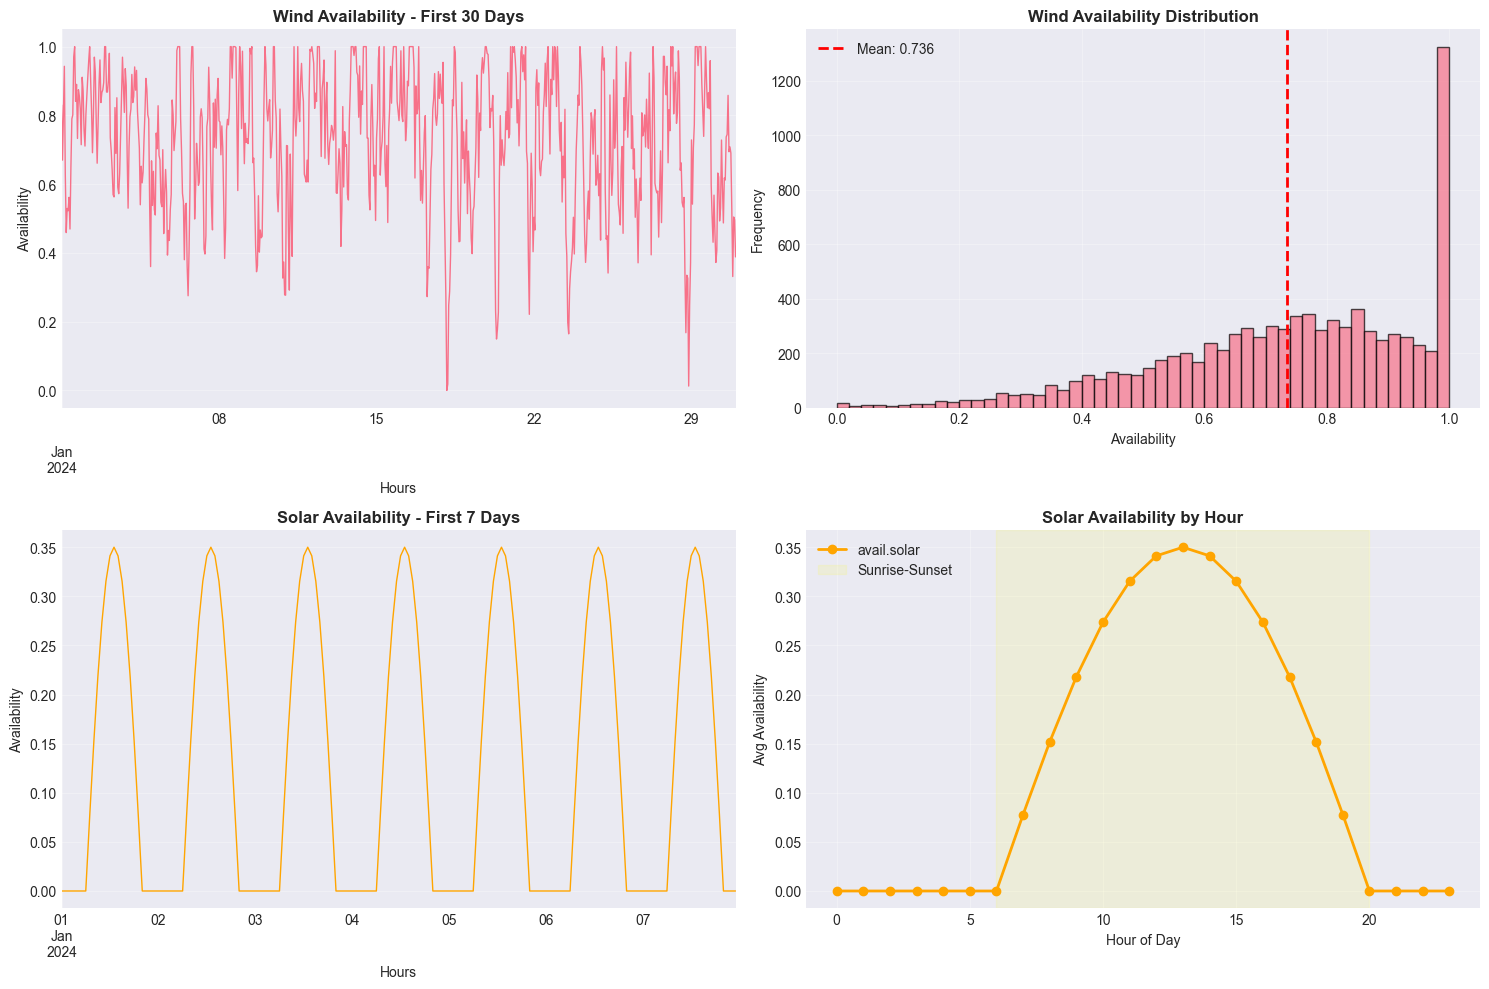


Renewable Availability Statistics:
  Wind: mean=0.736, std=0.210
  Solar: mean=0.129, std=0.138


In [25]:
has_renewables = 'avail.wind' in df.columns or 'avail.solar' in df.columns

if has_renewables:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Wind analysis
    if 'avail.wind' in df.columns:
        # Time series (first 30 days)
        ax = axes[0, 0]
        df['avail.wind'].iloc[:min(30*24, len(df))].plot(ax=ax, linewidth=1)
        ax.set_title('Wind Availability - First 30 Days', fontsize=12, fontweight='bold')
        ax.set_xlabel('Hours')
        ax.set_ylabel('Availability')
        ax.grid(True, alpha=0.3)
        
        # Distribution
        ax = axes[0, 1]
        df['avail.wind'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
        ax.axvline(df['avail.wind'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {df["avail.wind"].mean():.3f}')
        ax.set_title('Wind Availability Distribution', fontsize=12, fontweight='bold')
        ax.set_xlabel('Availability')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'No wind data', ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].axis('off')
        axes[0, 1].text(0.5, 0.5, 'No wind data', ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].axis('off')
    
    # Solar analysis
    if 'avail.solar' in df.columns:
        # Time series (first 7 days)
        ax = axes[1, 0]
        df['avail.solar'].iloc[:min(7*24, len(df))].plot(ax=ax, linewidth=1, color='orange')
        ax.set_title('Solar Availability - First 7 Days', fontsize=12, fontweight='bold')
        ax.set_xlabel('Hours')
        ax.set_ylabel('Availability')
        ax.grid(True, alpha=0.3)
        
        # By hour
        ax = axes[1, 1]
        solar_hourly = df.groupby('hour')['avail.solar'].mean()
        solar_hourly.plot(ax=ax, marker='o', linewidth=2, color='orange')
        ax.axvspan(6, 20, alpha=0.1, color='yellow', label='Sunrise-Sunset')
        ax.set_title('Solar Availability by Hour', fontsize=12, fontweight='bold')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Avg Availability')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No solar data', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].axis('off')
        axes[1, 1].text(0.5, 0.5, 'No solar data', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nRenewable Availability Statistics:")
    if 'avail.wind' in df.columns:
        print(f"  Wind: mean={df['avail.wind'].mean():.3f}, std={df['avail.wind'].std():.3f}")
    if 'avail.solar' in df.columns:
        print(f"  Solar: mean={df['avail.solar'].mean():.3f}, std={df['avail.solar'].std():.3f}")
else:
    print("No renewable availability data found")

## 8. Planned Outages

Validation of planned maintenance outages (typically summer months).


Planned Outages Validation:
  NUCLEAR:
    Non-outage mean: 0.9751
    Outage mean: 0.8581
    Reduction: 12.00%
  COAL:
    Non-outage mean: 0.9392
    Outage mean: 0.8455
    Reduction: 9.97%
  GAS:
    Non-outage mean: 0.9747
    Outage mean: 0.8967
    Reduction: 8.00%


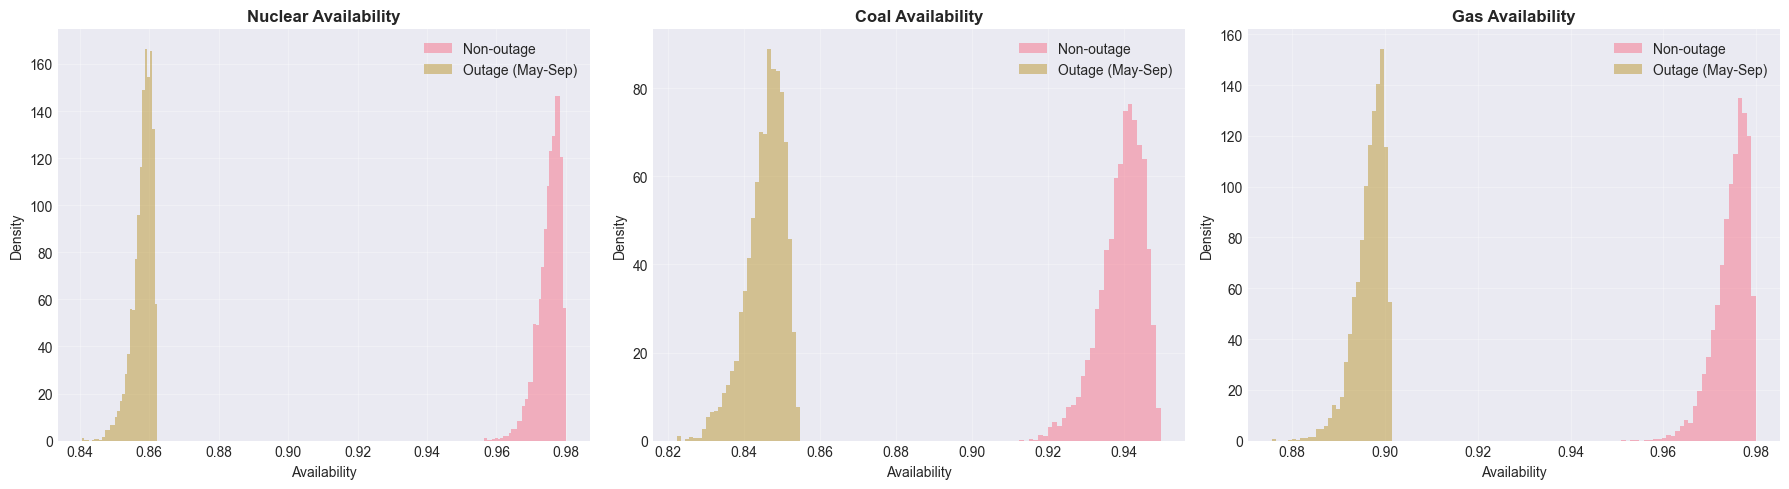

In [26]:
thermal_techs = [tech for tech in ['nuclear', 'coal', 'gas'] if f'avail.{tech}' in df.columns]

if thermal_techs:
    outage_months = [5, 6, 7, 8, 9]
    non_outage_months = [m for m in range(1, 13) if m not in outage_months]
    
    fig, axes = plt.subplots(1, len(thermal_techs), figsize=(6*len(thermal_techs), 5))
    if len(thermal_techs) == 1:
        axes = [axes]
    
    print("\nPlanned Outages Validation:")
    for idx, tech in enumerate(thermal_techs):
        col = f'avail.{tech}'
        
        outage_avail = df[df['month'].isin(outage_months)][col]
        non_outage_avail = df[df['month'].isin(non_outage_months)][col]
        
        axes[idx].hist(non_outage_avail, bins=30, alpha=0.5, label='Non-outage', density=True)
        axes[idx].hist(outage_avail, bins=30, alpha=0.5, label='Outage (May-Sep)', density=True)
        
        axes[idx].set_title(f'{tech.capitalize()} Availability', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Availability')
        axes[idx].set_ylabel('Density')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        
        # Print stats
        reduction = ((non_outage_avail.mean() - outage_avail.mean()) / non_outage_avail.mean() * 100)
        print(f"  {tech.upper()}:")
        print(f"    Non-outage mean: {non_outage_avail.mean():.4f}")
        print(f"    Outage mean: {outage_avail.mean():.4f}")
        print(f"    Reduction: {reduction:.2f}%")
    
    plt.tight_layout()
    plt.show()
else:
    print("No thermal availability data for outage analysis")

## 9. Generation Mix Evolution

How the generation mix changes over time (if multi-year simulation).

In [27]:
if gen_cols and len(df) > 8760:  # More than 1 year
    # Create year labels
    df['sim_year'] = df['year'] - df['year'].min() + 1
    
    # Average generation by year
    yearly_gen = df.groupby('sim_year')[gen_cols].mean()
    yearly_gen_pct = yearly_gen.div(yearly_gen.sum(axis=1), axis=0) * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Absolute generation
    ax = axes[0]
    yearly_gen.plot(kind='bar', stacked=True, ax=ax, width=0.7)
    ax.set_title('Average Generation by Year (MW)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Simulation Year')
    ax.set_ylabel('Generation (MW)')
    ax.legend([c.replace('Q_', '').capitalize() for c in gen_cols], title='Technology')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    # Percentage mix
    ax = axes[1]
    yearly_gen_pct.plot(kind='bar', stacked=True, ax=ax, width=0.7)
    ax.set_title('Generation Mix by Year (%)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Simulation Year')
    ax.set_ylabel('Generation Mix (%)')
    ax.legend([c.replace('Q_', '').capitalize() for c in gen_cols], title='Technology')
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print("\nGeneration Mix by Year:")
    print(yearly_gen_pct.round(1).to_string())
elif gen_cols:
    print("Simulation is 1 year or less - skipping year-by-year analysis")
else:
    print("No generation data available")

Simulation is 1 year or less - skipping year-by-year analysis


## 10. Capacity Evolution

How installed capacity changes over time (if applicable).

In [28]:
if cap_cols:
    # Check if capacities are changing
    cap_changes = {col: (df[col].iloc[-1] - df[col].iloc[0]) / df[col].iloc[0] * 100 
                   for col in cap_cols if df[col].iloc[0] != 0}
    
    has_changes = any(abs(change) > 1 for change in cap_changes.values())
    
    if has_changes:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Resample to daily for cleaner viz
        if len(df) > 10000:
            daily_cap = df[cap_cols].resample('D').mean()
        else:
            daily_cap = df[cap_cols]
        
        for col in cap_cols:
            label = col.replace('cap.', '').capitalize()
            daily_cap[col].plot(ax=ax, label=label, linewidth=2, alpha=0.8)
        
        ax.set_title('Capacity Evolution Over Time', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Capacity (MW)', fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\nCapacity Changes:")
        for col in cap_cols:
            start = df[col].iloc[0]
            end = df[col].iloc[-1]
            change = ((end - start) / start * 100) if start != 0 else 0
            tech = col.replace('cap.', '').capitalize()
            print(f"  {tech}: {start:.0f} MW → {end:.0f} MW ({change:+.1f}%)")
    else:
        print("Capacities are constant over the simulation period")
        print("\nInstalled Capacities:")
        for col in cap_cols:
            tech = col.replace('cap.', '').capitalize()
            print(f"  {tech}: {df[col].iloc[0]:.0f} MW")
else:
    print("No capacity data available")

Capacities are constant over the simulation period

Installed Capacities:
  Nuclear: 6000 MW
  Coal: 8000 MW
  Gas: 12000 MW
  Wind: 7000 MW
  Solar: 5000 MW


## 11. Price Analysis

Detailed analysis of market clearing prices.

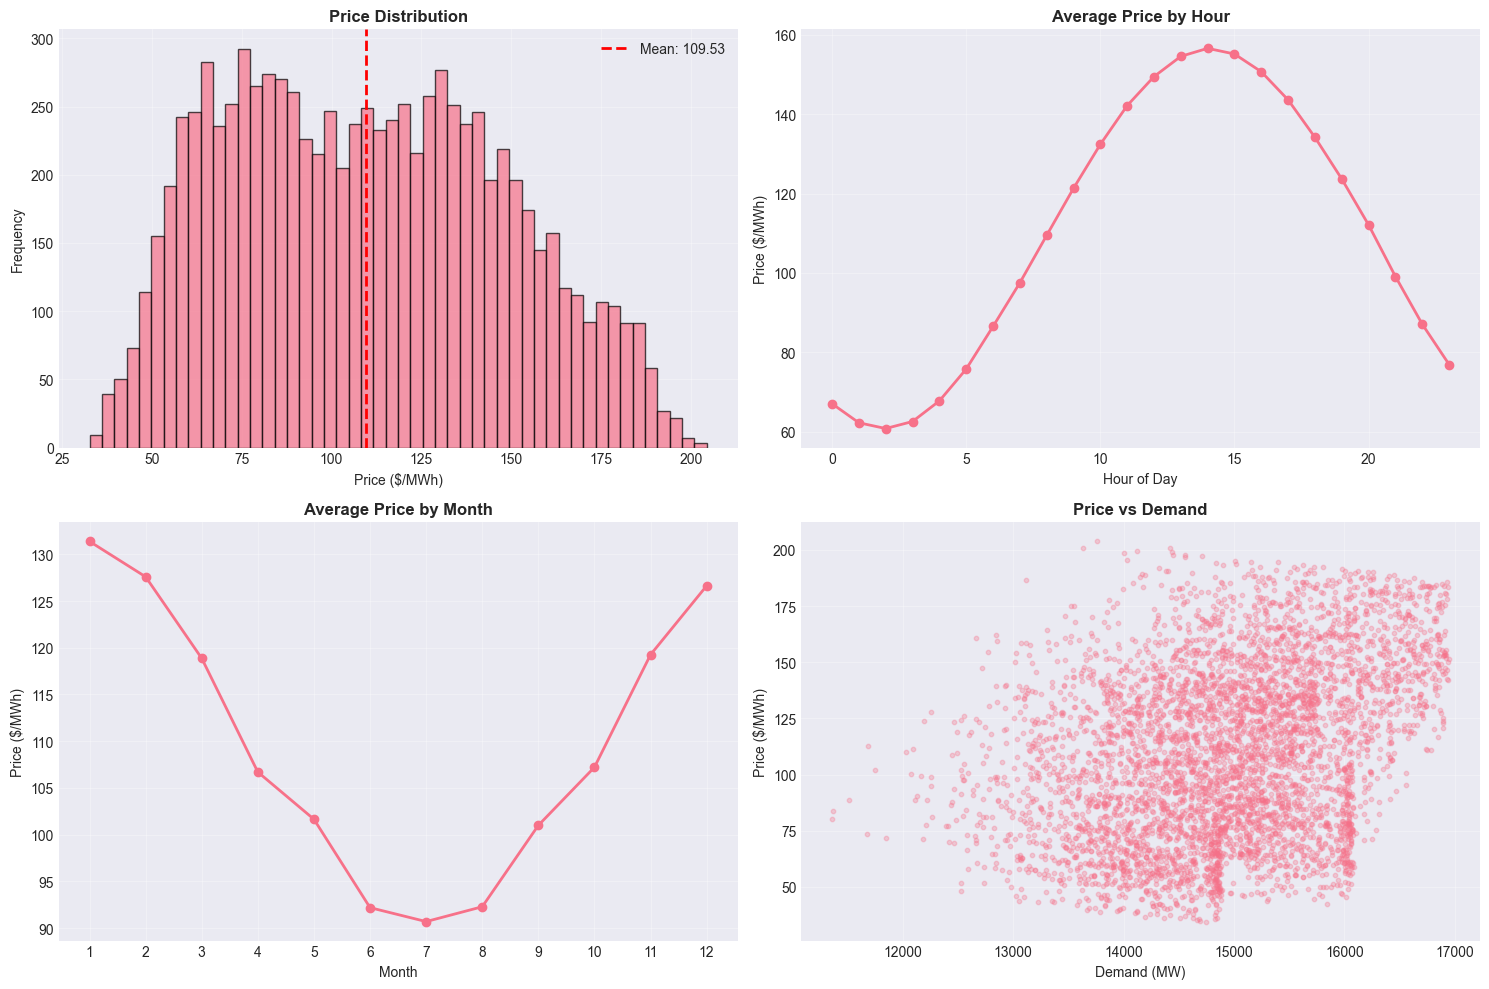


Price Statistics:
  Mean: 109.53 $/MWh
  Std: 38.11 $/MWh
  Min: 32.64 $/MWh
  Max: 204.43 $/MWh


In [29]:
if 'price' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribution
    ax = axes[0, 0]
    df['price'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
    ax.axvline(df['price'].mean(), color='red', linestyle='--', linewidth=2,
              label=f'Mean: {df["price"].mean():.2f}')
    ax.set_title('Price Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Price ($/MWh)')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # By hour
    ax = axes[0, 1]
    hourly_price = df.groupby('hour')['price'].mean()
    hourly_price.plot(ax=ax, marker='o', linewidth=2)
    ax.set_title('Average Price by Hour', fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Price ($/MWh)')
    ax.grid(True, alpha=0.3)
    
    # By month
    ax = axes[1, 0]
    monthly_price = df.groupby('month')['price'].mean()
    monthly_price.plot(ax=ax, marker='o', linewidth=2)
    ax.set_title('Average Price by Month', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel('Price ($/MWh)')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    
    # Price vs Demand scatter
    ax = axes[1, 1]
    if 'q_cleared' in df.columns:
        # Sample if too many points
        if len(df) > 5000:
            sample_df = df.sample(5000)
        else:
            sample_df = df
        ax.scatter(sample_df['q_cleared'], sample_df['price'], alpha=0.3, s=10)
        ax.set_title('Price vs Demand', fontsize=12, fontweight='bold')
        ax.set_xlabel('Demand (MW)')
        ax.set_ylabel('Price ($/MWh)')
    else:
        ax.text(0.5, 0.5, 'No demand data', ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nPrice Statistics:")
    print(f"  Mean: {df['price'].mean():.2f} $/MWh")
    print(f"  Std: {df['price'].std():.2f} $/MWh")
    print(f"  Min: {df['price'].min():.2f} $/MWh")
    print(f"  Max: {df['price'].max():.2f} $/MWh")
else:
    print("No price data available")

## 12. Summary Statistics

Key statistics for all major variables.

In [30]:
summary_cols = ['price', 'q_cleared'] + fuel_cols + gen_cols
summary_cols = [c for c in summary_cols if c in df.columns]

if summary_cols:
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(df[summary_cols].describe().T[['mean', 'std', 'min', 'max']].to_string())
else:
    print("No data available for summary statistics")


SUMMARY STATISTICS
                   mean          std           min           max
price        109.531532    38.113508     32.638664    204.430065
q_cleared  14927.492688   968.453960  11358.441292  16949.412878
fuel.gas      49.780473    26.242570     13.713162    134.039700
fuel.coal     28.958813     5.733971     15.000000     51.106816
Q_nuclear   5556.220794   347.088441   5043.664969   5879.791439
Q_coal      5169.905742  3200.482606      0.000000   7596.171692
Q_gas       7162.635959  5519.197386      0.000000  11759.296728
Q_wind      5148.556729  1467.970658      0.000000   7000.000000
Q_solar      647.153316   688.822122      0.000000   1750.000000


## 13. Validation Checks

Automated validation of key simulation properties.

In [31]:
print("\n" + "="*80)
print("VALIDATION CHECKS")
print("="*80)

# 1. Supply-demand balance
if gen_cols and 'q_cleared' in df.columns:
    print("\n1. SUPPLY-DEMAND BALANCE:")
    df['total_supply'] = df[gen_cols].sum(axis=1)
    balance_error = (df['total_supply'] - df['q_cleared']).abs().mean()
    relative_error = (balance_error / df['q_cleared'].mean() * 100)
    print(f"   Average absolute error: {balance_error:.2f} MW")
    print(f"   Average relative error: {relative_error:.4f}%")
    if relative_error < 0.01:
        print(f"   ✓ Excellent balance")
    elif relative_error < 1:
        print(f"   ✓ Good balance")
    else:
        print(f"   ⚠ Balance error may be significant")

# 2. Demand seasonality
if 'q_cleared' in df.columns:
    print("\n2. DEMAND SEASONALITY:")
    peak_demand = df[df['hour'] == 14]['q_cleared'].mean()
    offpeak_demand = df[df['hour'] == 4]['q_cleared'].mean()
    daily_var = ((peak_demand - offpeak_demand) / offpeak_demand * 100)
    print(f"   Peak (14:00): {peak_demand:.0f} MW")
    print(f"   Off-peak (04:00): {offpeak_demand:.0f} MW")
    print(f"   Daily variation: {daily_var:.1f}%")
    if daily_var > 10:
        print(f"   ✓ Daily seasonality present")
    else:
        print(f"   ⚠ Weak or no daily seasonality")

# 3. Renewable patterns
if 'avail.solar' in df.columns:
    print("\n3. SOLAR DIURNAL PATTERN:")
    solar_day = df[(df['hour'] >= 10) & (df['hour'] <= 16)]['avail.solar'].mean()
    solar_night = df[(df['hour'] < 6) | (df['hour'] > 20)]['avail.solar'].mean()
    print(f"   Daytime avg (10-16h): {solar_day:.3f}")
    print(f"   Nighttime avg: {solar_night:.3f}")
    if solar_day > solar_night * 5:
        print(f"   ✓ Strong diurnal pattern")
    elif solar_day > solar_night:
        print(f"   ✓ Diurnal pattern present")
    else:
        print(f"   ⚠ Weak or no diurnal pattern")

# 4. Price reasonableness
if 'price' in df.columns:
    print("\n4. PRICE VALIDATION:")
    negative_prices = (df['price'] < 0).sum()
    pct_negative = negative_prices / len(df) * 100
    print(f"   Mean price: {df['price'].mean():.2f} $/MWh")
    print(f"   Negative prices: {negative_prices} ({pct_negative:.2f}%)")
    if df['price'].mean() > 0 and df['price'].mean() < 200:
        print(f"   ✓ Price range reasonable")
    else:
        print(f"   ⚠ Price range unusual")

# 5. Data completeness
print("\n5. DATA COMPLETENESS:")
missing = df[summary_cols].isnull().sum().sum() if summary_cols else 0
total_cells = len(df) * len(summary_cols) if summary_cols else 0
print(f"   Total missing values: {missing} / {total_cells}")
if missing == 0:
    print(f"   ✓ No missing data")
else:
    pct_missing = missing / total_cells * 100
    print(f"   ⚠ {pct_missing:.2f}% data missing")

print("\n" + "="*80)


VALIDATION CHECKS

1. SUPPLY-DEMAND BALANCE:
   Average absolute error: 10253.17 MW
   Average relative error: 68.6865%
   ⚠ Balance error may be significant

2. DEMAND SEASONALITY:
   Peak (14:00): 15381 MW
   Off-peak (04:00): 14703 MW
   Daily variation: 4.6%
   ⚠ Weak or no daily seasonality

3. SOLAR DIURNAL PATTERN:
   Daytime avg (10-16h): 0.316
   Nighttime avg: 0.000
   ✓ Strong diurnal pattern

4. PRICE VALIDATION:
   Mean price: 109.53 $/MWh
   Negative prices: 0 (0.00%)
   ✓ Price range reasonable

5. DATA COMPLETENESS:
   Total missing values: 0 / 78840
   ✓ No missing data



## 14. Scenario Summary

Final summary of the scenario characteristics.

In [32]:
print("\n" + "="*80)
print("SCENARIO SUMMARY")
print("="*80)

print(f"\nFile: {data_file.name}")
print(f"Duration: {(df.index.max() - df.index.min()).days} days ({(df.index.max() - df.index.min()).days / 365:.1f} years)")
print(f"Timesteps: {len(df):,}")
print(f"Frequency: {pd.infer_freq(df.index) or 'Unknown (irregular)'}")

if gen_cols:
    print(f"\nGeneration Technologies: {', '.join([c.replace('Q_', '') for c in gen_cols])}")
    print(f"\nAverage Generation Mix:")
    for col in gen_cols:
        tech = col.replace('Q_', '').capitalize()
        avg_gen = df[col].mean()
        total_gen = df[gen_cols].sum(axis=1).mean()
        pct = (avg_gen / total_gen * 100) if total_gen > 0 else 0
        print(f"  {tech}: {avg_gen:.0f} MW ({pct:.1f}%)")

if 'price' in df.columns:
    print(f"\nAverage Market Price: {df['price'].mean():.2f} $/MWh")

if 'q_cleared' in df.columns:
    print(f"Average Demand: {df['q_cleared'].mean():.0f} MW")

print("\n" + "="*80)
print("✓ Validation complete")
print("="*80)


SCENARIO SUMMARY

File: gas_crisis_scenario_v1_2025_11_06_00_22.pkl
Duration: 364 days (1.0 years)
Timesteps: 8,760
Frequency: h

Generation Technologies: nuclear, coal, gas, wind, solar

Average Generation Mix:
  Nuclear: 5556 MW (23.5%)
  Coal: 5170 MW (21.8%)
  Gas: 7163 MW (30.2%)
  Wind: 5149 MW (21.7%)
  Solar: 647 MW (2.7%)

Average Market Price: 109.53 $/MWh
Average Demand: 14927 MW

✓ Validation complete
